# preprocessing EEG data

In [5]:
!pip install mne

In [6]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from datetime import datetime
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from datetime import datetime, timezone

########################################################################################
########################################################################################
#Firebase initializationn
def initialize_firebase_app():
    # Check if the Firebase app is already initialized
    if not firebase_admin._apps:
        # Initialize Firebase app
        cred = credentials.Certificate("firebase/wl-nasa-tlx-firebase-adminsdk-f62th-21f83967e3.json")
        firebase_admin.initialize_app(cred)
    else:
        print("Firebase app is already initialized.")

    return

#########################################################################################
#########################################################################################
#Firebase - Extracting Timestamps for task timing defining
def extract_timestamps_from_firestore(user_id):
    # Initialize Firebase app
    firebase_app = initialize_firebase_app()

    # Get a Firestore database instance
    db = firestore.client(firebase_app)

    # Specify the collection name
    collection_name = "Software Engineering"

    # Get all document names in the specified collection
    documents = db.collection(collection_name).list_documents()

    # Extract timestamps from document names for the specified user
    timestamps = []
    for doc in documents:
        document_name = doc.id
        if f"userId: {user_id}" in document_name:
            timestamp_start = document_name.find("timestamp: ") + len("timestamp: ")
            timestamp_end = document_name.find(".")
            timestamp = document_name[timestamp_start:timestamp_end]
            timestamps.append(timestamp)
    print(timestamps)
    # Return extracted timestamps
    return timestamps

#####################################################################################################
#####################################################################################################
#Retriving NASA-TLX values from firebase
def extract_nasa_tlx_firestore(collection_name, user_id):
    # Initialize Firebase app
    firebase_app = initialize_firebase_app()

    # Get a Firestore database instance
    db = firestore.client(firebase_app)

    # List to store desired values for each document
    desired_values = []

    # Query documents in the specified collection
    query = db.collection(collection_name).stream()

    # Iterate through query results
    for doc in query:
        # Get the document ID
        document_id = doc.id

        # Check if the document belongs to the specified user ID
        if f"userId: {user_id}" in document_id:
            # Extract field values from the document
            document_data = doc.to_dict().values()

            # Calculate sum of all field values in the document
            total_sum = sum(document_data)

            # Calculate the average of field values
            average_value = total_sum / 60

            # Multiply the average value by 5
            multiplied_value = average_value * 5

            # Round the calculated value to the nearest decimal
            rounded_value = round(multiplied_value, 0)

            rounded_value = str(rounded_value)

            # Append the rounded value to the list
            desired_values.append(rounded_value)
    print(desired_values)
    # Return the list of desired values
    return desired_values


###################################################################################################
###################################################################################################
#Loading CSV file
def load_and_preprocess(filepath, timestamps=None, output_dir='research_codes/signal_images'):
    """Loads EEG data from a CSV file, extracts channel names, and creates a preprocessed MNE Raw object.

    Args:
        filepath (str): Path to the CSV file containing EEG data.
        timestamps (list of float or None): List of timestamps to define segments of data. If None, process all data.
        output_dir (str): Directory to save the signal images.

    Returns:
        list of mne.io.Raw: List of preprocessed MNE Raw objects for each segment defined by timestamps.
    """
    # Extract file name from the file path
    file_name = os.path.splitext(os.path.basename(filepath))[0]
    user_id = file_name.split('-')[-1].split('_')[0]  # Extract user ID from the file name

    # Load data using pandas
    df = pd.read_csv(filepath, header=None, low_memory=False)

    # Extract channel names from the second row
    channel_names = df.iloc[1, 3:18].astype(str).tolist()  # Convert to string

    # Ensure that channel_names contain at most 14 channels
    channel_names = channel_names[:14]

    # Load data from the third row onwards and from the 4th to 17th column
    data = df.iloc[2:, 3:18].values.astype(float)

    raw_list = []

    if timestamps is None:
        timestamps = [None]

    data_segment = None

    for idx, timestamp in enumerate(timestamps):
        # Process data up to the specified timestamp
        if timestamp is not None:
            timestamps_df = df.iloc[2:, 0].values.astype(float)
            last_index = np.argmax(timestamps_df > timestamp)
            if last_index == 0:
                print(f"Specified timestamp {idx + 1} is before the first recorded data. Processing all data.")
            else:
                data_segment = data[:last_index]
                # Print Firebase and CSV timestamps at each range processed
                print(f"Firebase Timestamp: {timestamp}, CSV Timestamp: {df.iloc[last_index, 0]}")
        else:
            data_segment = data

        # Sampling frequency (adjust based on your data)
        sampling_freq = 1000

        # Channel types (assuming all EEG)
        channel_types = ['eeg'] * len(channel_names)

        # Create MNE Info object
        info = mne.create_info(ch_names=channel_names, ch_types=channel_types, sfreq=sampling_freq)

        # Create RawArray
        raw = mne.io.RawArray(data_segment.T, info)

        # Basic filtering for removing line noise and slow drifts
        raw.filter(1., 40., fir_design='firwin')

        raw_list.append(raw)

        # Plot and save EEG signal plots for each channel
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        for channel in range(len(raw.ch_names)):
            plt.figure()
            plt.plot(raw._data[channel], color='blue')  # Plot EEG data for the channel
            plt.title(f'EEG Signal for Channel {raw.ch_names[channel]}')
            plt.xlabel('Time (samples)')
            plt.ylabel('Amplitude')
            plt.savefig(f'{output_dir}/signal_{file_name}_{idx+1}_{raw.ch_names[channel]}.png')
            plt.close()

    return raw_list

######################################################################################################
######################################################################################################
#Applying Apply Independent Component Analysis (ICA) for artifact removal.
def apply_ica(raw_list):
    ica_list = []
    for raw in raw_list:
        # Initialize ICA
        ica = mne.preprocessing.ICA(n_components=len(raw.ch_names), random_state=42)

        # Fit ICA
        ica.fit(raw)

        ica_list.append(ica)

    return ica_list

######################################################################################################
######################################################################################################
#Calculates Power Spectral Density (PSD) using the psd_array_welch method.
def calculate_psd(raw_list, ica_list):
  psds_list = []
  freqs_list = []
  for raw, ica in zip(raw_list, ica_list):
    # Apply ICA to remove artifact components
    raw_ica = ica.apply(raw.copy())
    # Define frequency range of interest
    fmin, fmax = 1., 40.
    # Get sampling frequency from Raw object
    sfreq = raw.info['sfreq']
    # Compute PSD using psd_array_welch with sfreq argument
    psds, freqs = mne.time_frequency.psd_array_welch(raw_ica.get_data(), sfreq=sfreq, fmin=fmin, fmax=fmax, n_fft=2048)
    psds = 10. * np.log10(psds)  # Convert power to dB
    psds_list.append(psds)
    freqs_list.append(freqs)
  return psds_list, freqs_list

####################################################################################################
####################################################################################################
#Generates combined PSD images with colormaps, line plots, and contrasting backgrounds.
def psd_to_image(psds_list, freqs_list, channel_names, csv_name, timestamps, nasa_tlx_values_list,output_dir='research_codes/psd_images_combined'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    j = 1
    for idx, (psds, freqs) in enumerate(zip(psds_list, freqs_list)):
        timestamp = timestamps[idx]
        nasa_tlx_value = nasa_tlx_values_list[idx]
        folder_name = nasa_tlx_value
        folder_path = os.path.join(output_dir, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        j = j + 1
        k = 1
        for i, channel_name in enumerate(channel_names):
            # Create the plot
            fig, ax = plt.subplots()

            # Plot PSD with hot colormap
            im = ax.imshow(
                psds[i][:, np.newaxis].T,
                extent=[freqs[0], freqs[-1], 0, psds[i].max()],
                cmap='hot',
                aspect='auto',
                origin='lower',
                vmin=psds[i].min(),
                vmax=psds[i].max()
            )

            # Add line plot on top of the colormap
            ax.plot(freqs, psds[i], color='black', linewidth=2)  # Adjust line style as desired

            # Customize labels and title
            ax.set_xlabel('Frequency (Hz)')
            ax.set_ylabel('Power Spectral Density (dB)')
            ax.set_title(f'PSD: {channel_name}')

            # Add colorbar using the mappable object (imshow)
            plt.colorbar(im, ax=ax, label='Power Spectral Density (dB)')
            k = k + 1
            # Save the image
            plt.savefig(os.path.join(folder_path, f'psd{csv_name}_{folder_name}_{channel_name}_{j}_{k}.png'))
            plt.close()

########################################################################################################
########################################################################################################
# Function to convert a timestamp string to Unix timestamp because the CSV file has this type
def convert_to_unix(timestamp_str):
    # Convert timestamp string to datetime object
    timestamp_dt = datetime.strptime(timestamp_str, "%Y-%m-%d %H:%M:%S")
    # Convert datetime object to Unix timestamp (seconds since the epoch)
    timestamp_unix = int(timestamp_dt.timestamp())
    return timestamp_unix
#######################################################################################################
#######################################################################################################

#######################################################################################################
###Inmplementation###
#######################################################################################################
#Extracting Self Recorded NASA-TLX Workload data from firebase
collection_name = "Software Engineering"

# Loading the CSV file
filepaths = ['MWR-24-1_EEG.csv', 'MWR-24-3_EEG.csv', 'MWR-24-4_EEG.csv', 'MWR-24-5_EEG.csv']
# Names for saving the images
# Iterate over each CSV file
for filepath in filepaths:
    # Extract the user ID from the file name
    user_id = os.path.splitext(os.path.basename(filepath))[0].split('-')[-1].split('_')[0]
    print("#################################################################")
    print(filepath)
    # Call the function to get the timestamps for the specific user
    timestamps = extract_timestamps_from_firestore(user_id)

    # Convert each timestamp to Unix timestamp and store in a list
    timestamps_unix = []
    for timestamp in timestamps:
        timestamp_unix = convert_to_unix(timestamp)
        timestamp_unix = timestamp_unix - 10800
        timestamps_unix.append(timestamp_unix)

    # Now timestamps_unix list contains Unix timestamps for each extracted timestamp
    print("Unix Timestamps:")
    for timestamp_unix in timestamps_unix:
        print(timestamp_unix)

    # Extracting Self Recorded NASA-TLX Workload data from firebase
    collection_name = "Software Engineering"

    # Call the function to get the NASA TLX values for the specific user
    nasa_tlx_values = extract_nasa_tlx_firestore(collection_name, user_id)

    # Ensure that NASA TLX values are found for the user
    if not nasa_tlx_values:
        print(f"No NASA TLX values found for user ID {user_id}. Skipping processing for this file.")
        continue

    # Names for saving the images
    csv_name = os.path.splitext(os.path.basename(filepath))[0]

    # Load and preprocess the CSV file
    raw_list = load_and_preprocess(filepath, timestamps_unix)

    # Apply ICA
    ica_list = apply_ica(raw_list)

    # Calculate PSD
    psds_list, freqs_list = calculate_psd(raw_list, ica_list)

    # Generate PSD images
    psd_to_image(psds_list, freqs_list, raw_list[0].ch_names, csv_name, timestamps_unix, nasa_tlx_values)

##########################################################################################################


#################################################################
MWR-24-1_EEG.csv
['2024-05-11 22:58:17', '2024-05-11 22:59:25', '2024-05-11 23:00:52', '2024-05-11 23:02:44', '2024-05-11 23:04:18', '2024-05-11 23:05:13', '2024-05-11 23:06:30']
Unix Timestamps:
1715457497
1715457565
1715457652
1715457764
1715457858
1715457913
1715457990
Firebase app is already initialized.
['3.0', '3.0', '3.0', '3.0', '3.0', '3.0', '3.0']
Firebase Timestamp: 1715457497, CSV Timestamp: 1715457497
Creating RawArray with float64 data, n_channels=14, n_times=132365
    Range : 0 ... 132364 =      0.000 ...   132.364 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 

#Cleaning Data folder

In [7]:
#!rm -rf research_codes

#Importing Libraries

In [8]:
import zipfile
import argparse
import random
!pip install gdown
import gdown
import tarfile

import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from PIL import Image
import time

#Checking the device and selecting

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Device:', device)

Device: cuda:0


#Downloading psdImages Dataset

In [10]:
# Define the path to the psdImages data
psdImages_path = '/content/research_codes/psd_images_combined'


#Displaying some sample files

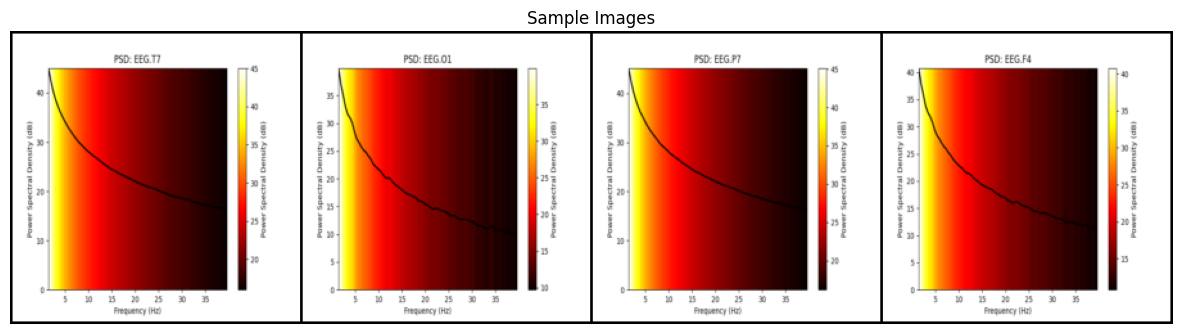

In [11]:
# Display some sample images from the training dataset
transform_common = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
psdImages_dataset_show = datasets.ImageFolder(root=psdImages_path, transform=transform_common)
sample_loader = torch.utils.data.DataLoader(psdImages_dataset_show, batch_size=4, shuffle=True)
sample_batch, sample_labels = next(iter(sample_loader))

plt.figure(figsize=(15, 20))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(sample_batch, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

#Loading data, Transform defining, Data Splitting, DataLoader definining and Activity showcasing

In [12]:
# Load psdImages dataset

# Training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=216, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#downloadingn different instances of data for different transforms
psdImages_dataset_training = datasets.ImageFolder(root=psdImages_path, transform=train_transform)
psdImages_dataset_val = datasets.ImageFolder(root=psdImages_path, transform=val_transform)
psdImages_dataset_testing = datasets.ImageFolder(root=psdImages_path, transform=test_transform)

# Split the psdImages dataset into train and validation sets
train_size = int(0.6 * len(psdImages_dataset_training))
val_size = int(0.2 * len(psdImages_dataset_training))
test_size = len(psdImages_dataset_training) - train_size - val_size

#for transform of train
train_dataset, _, _ = torch.utils.data.random_split(psdImages_dataset_training,
                                                                         [train_size, val_size, test_size])
#for transform of validation
_, val_dataset, _ = torch.utils.data.random_split(psdImages_dataset_val,
                                                                         [train_size, val_size, test_size])
#for transform of testing
_, _, test_dataset = torch.utils.data.random_split(psdImages_dataset_testing,
                                                                         [train_size, val_size, test_size])

# Apply the transforms to the datasets
train_dataset.dataset.transform=train_transform
val_dataset.dataset.transform=val_transform
test_dataset.dataset.transform=test_transform

# Create data loaders for psdImages
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

#Size Data
num_classes_psdImages = len(psdImages_dataset_training.classes)
print("Number of Classes: ",num_classes_psdImages)
print("Train Size: ", train_size)
print("Val Size: ", val_size)
print("Test Size: ", test_size)

print("Train Dataset Transform: ", train_dataset.dataset.transform)
print("Validation Dataset Transform: ", val_dataset.dataset.transform)
print("Test Dataset Transform: ", test_dataset.dataset.transform)

class_indices = psdImages_dataset_training.class_to_idx
print(class_indices)

Number of Classes:  5
Train Size:  235
Val Size:  78
Test Size:  79
Train Dataset Transform:  Compose(
    RandomResizedCrop(size=(216, 216), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Validation Dataset Transform:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test Dataset Transform:  Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=

#Checking the data type of the images after transforming

In [13]:
# check the data type of images in a batch
def check_image_data_type(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    # Checking the data type of the images
    data_type = type(images)
    return data_type

# Checking the data type for train_loader
train_data_type = check_image_data_type(train_loader)
print("Train Loader Image Data Type:", train_data_type)

# Checking the data type for val_loader
val_data_type = check_image_data_type(val_loader)
print("Validation Loader Image Data Type:", val_data_type)

# Checking the data type for test_loader
test_data_type = check_image_data_type(test_loader)
print("Test Loader Image Data Type:", test_data_type)

Train Loader Image Data Type: <class 'torch.Tensor'>
Validation Loader Image Data Type: <class 'torch.Tensor'>
Test Loader Image Data Type: <class 'torch.Tensor'>


#Displaying images after applying transfoms

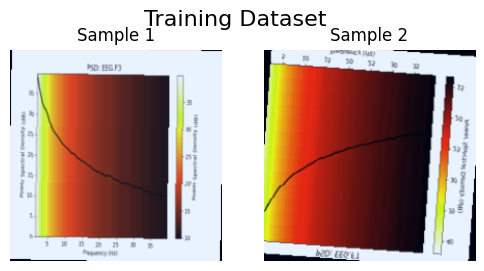

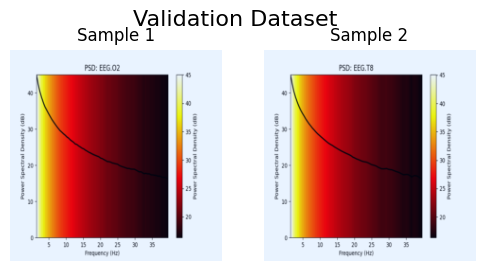

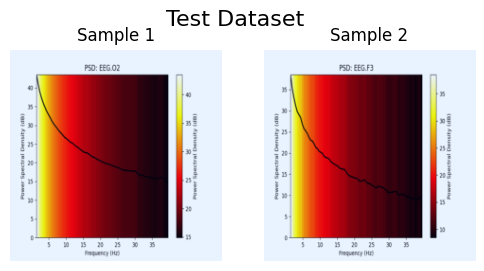

In [14]:
# display images after transforming
def show_images(images, title):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(num_images):
        ax = axes[i] if num_images > 1 else axes
        # Normalizing
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Sample {i + 1}")
    plt.show()

# getting samples from the data loader
def get_sample(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    return images, labels

# Getting sample from each dataset
train_images, _ = get_sample(train_loader)
val_images, _ = get_sample(val_loader)
test_images, _ = get_sample(test_loader)

# Showing transformed images according to the transformations applied in the previous step
show_images([train_images[0], train_images[1]], "Training Dataset")
show_images([val_images[0], val_images[1]], "Validation Dataset")
show_images([test_images[0], test_images[1]], "Test Dataset")


#Downloading the model resnet50 and its weights

In [15]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install torch==2.1.0 torchvision==0.16.0 --index-url https://download.pytorch.org/whl/cu118
# Choose a Dl architecture
from torchvision.models import resnet34

# Load pre-trained ResNet50 model
weights="IMAGENET1K_V1"
pretrained_model = resnet34(weights=weights)
pretrained_model = pretrained_model.to(device)

print(pretrained_model)

Looking in indexes: https://download.pytorch.org/whl/cu118
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

#Checking the model summary

In [16]:
!pip install torchsummary
from torchsummary import summary

#summary(pretrained_model, (3, 224, 224))

#Modifying final layer to align with the dataset classes

In [17]:
# unfreeze all layers
for param in pretrained_model.parameters():
    param.requires_grad = True
    param.data = param.data.to(device)

# Modifying final layer
num_classes_psdImages = len(psdImages_dataset_training.classes)
dropout = 0.5
pretrained_model.fc = nn.Sequential(
    nn.Dropout(p=dropout),
    nn.Linear(pretrained_model.fc.in_features, num_classes_psdImages)
)

pretrained_model = pretrained_model.to(device)

#pretrained_model

#Training Function

In [18]:
#Training
class Trainer:
    def __init__(self, pretrained_model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs):
      self.pretrained_model = pretrained_model
      self.train_loader = train_loader
      self.val_loader = val_loader
      self.optimizer = optimizer
      self.criterion = criterion
      self.scheduler = scheduler
      self.num_epochs = num_epochs
    def training(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        self.pretrained_model = self.pretrained_model.to(device)

        history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
        best_valid_loss = float('inf')
        early_stopping_counter = 0

        for epoch in range(self.num_epochs):
            self.pretrained_model.train()

            total_loss = 0.0
            true_labels_train = []
            predicted_labels_train = []

            # Loss and Accuracy within the epoch
            train_loss = 0.0
            train_acc = 0.0

            valid_loss = 0.0
            valid_acc = 0.0

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.pretrained_model(inputs)
                loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

                # Computing accuracy
                predictions = torch.max(outputs.data, 1)[1]
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                train_loss += loss.item() * inputs.size(0)
                train_acc += acc.item() * inputs.size(0)

                true_labels_train.extend(labels.cpu().numpy())
                predicted_labels_train.extend(predictions.cpu().numpy())

            average_loss = total_loss / len(self.train_loader)
            train_accuracy = accuracy_score(true_labels_train, predicted_labels_train)
            history['train_loss'].append(average_loss)
            history['train_acc'].append(train_accuracy)

            # Validation
            true_labels_val = []
            predicted_labels_val = []

            self.pretrained_model.eval()

            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.pretrained_model(inputs)

                    loss = self.criterion(outputs, labels)
                    valid_loss += loss.item() * inputs.size(0)

                    predictions = torch.max(outputs.data, 1)[1]
                    correct_counts = predictions.eq(labels.data.view_as(predictions))
                    acc = torch.mean(correct_counts.type(torch.FloatTensor))
                    valid_acc += acc.item() * inputs.size(0)

                    true_labels_val.extend(labels.cpu().numpy())
                    predicted_labels_val.extend(predictions.cpu().numpy())

                # Mapping class indices names
                class_idx_to_name = {idx: class_name for class_name, idx in class_indices.items()}
                true_labels_val = [class_idx_to_name[idx] for idx in true_labels_val]
                predicted_labels_val = [class_idx_to_name[idx] for idx in predicted_labels_val]

                # average validation loss and validation accuracy
                avg_valid_loss = valid_loss / len(self.val_loader.dataset)
                avg_valid_acc = accuracy_score(true_labels_val, predicted_labels_val)

                history['valid_loss'].append(avg_valid_loss)
                history['valid_acc'].append(avg_valid_acc)

            print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {avg_valid_acc:.4f}")

            # Updating the learning rate
            scheduler.step()

        return history

#Optimizer

In [19]:
#Optimizer
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.0001, weight_decay=0.0)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)


#Training Process

In [20]:
#Training process
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(pretrained_model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=20)
history = trainer.training()


cuda
Epoch 1/20, Training Loss: 1.7362, Training Accuracy: 0.2553, Validation Loss: 1.6994, Validation Accuracy: 0.2051
Epoch 2/20, Training Loss: 1.6863, Training Accuracy: 0.2766, Validation Loss: 1.5026, Validation Accuracy: 0.2436
Epoch 3/20, Training Loss: 1.6070, Training Accuracy: 0.2638, Validation Loss: 1.3829, Validation Accuracy: 0.4103
Epoch 4/20, Training Loss: 1.5684, Training Accuracy: 0.3447, Validation Loss: 1.3429, Validation Accuracy: 0.4487
Epoch 5/20, Training Loss: 1.5195, Training Accuracy: 0.3745, Validation Loss: 1.3317, Validation Accuracy: 0.4487
Epoch 6/20, Training Loss: 1.4390, Training Accuracy: 0.3787, Validation Loss: 1.2926, Validation Accuracy: 0.4744
Epoch 7/20, Training Loss: 1.3901, Training Accuracy: 0.4255, Validation Loss: 1.2317, Validation Accuracy: 0.5897
Epoch 8/20, Training Loss: 1.2912, Training Accuracy: 0.4766, Validation Loss: 1.1488, Validation Accuracy: 0.5897
Epoch 9/20, Training Loss: 1.3569, Training Accuracy: 0.4298, Validation Lo

# Plotting loss and accuracy variations

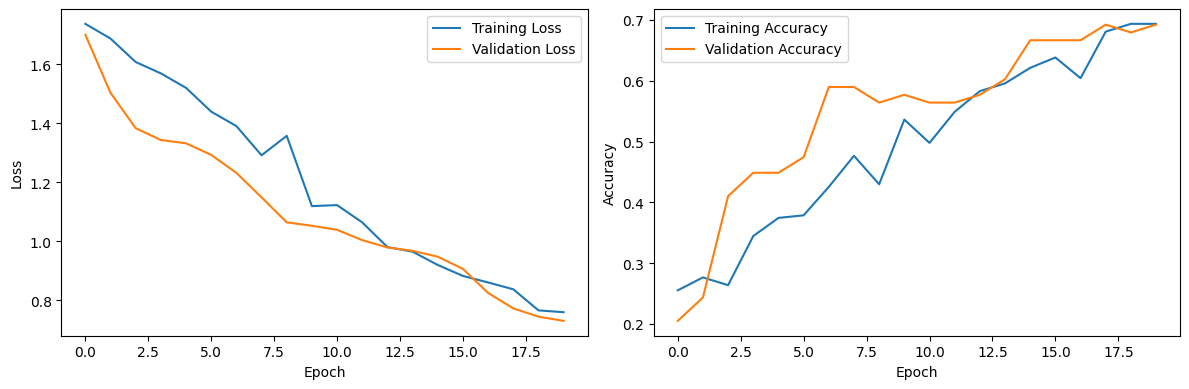

In [21]:
# Plotting loss and accuracy variations
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['valid_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
#testing
def testSetAccuracy(model, test_loader, criterion):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    true_labels_test = []
    predicted_labels_test = []

    # test accuracy history
    test_acc_history = []

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # to evaluation mode
        model.eval()

        # Test loop
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, labels)

            # collecting the loss
            test_loss += loss.item() * inputs.size(0)

            # Converting for accuracy calculation
            true_labels_test.extend(labels.cpu().numpy())
            predicted_labels_test.extend(torch.argmax(outputs, 1).cpu().numpy())

            # Calculate accuracy
            correct_counts = torch.sum(torch.argmax(outputs, 1) == labels)
            acc = correct_counts.item() / labels.size(0)

            # collecting accuracy
            test_acc += acc * inputs.size(0)

            # test accuracy at each batch
            test_acc_history.append(acc)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc))

    # average test loss and test accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_acc = test_acc / len(test_loader.dataset)

    # Calculating accuracy
    test_accuracy = accuracy_score(true_labels_test, predicted_labels_test)

    print("Test Accuracy (from sklearn): {:.4f}".format(test_accuracy))
    print("Average Test Loss: {:.4f}, Average Test Accuracy: {:.4f}".format(avg_test_loss, avg_test_acc))

    # Returning values
    return avg_test_loss, avg_test_acc, test_accuracy, test_acc_history


In [32]:
# Testing
avg_test_loss, avg_test_acc, test_accuracy, test_acc_history = testSetAccuracy(pretrained_model, test_loader, criterion)
print("avg_test_loss: ", avg_test_loss)
print("avg_test_Accuracy: ", avg_test_acc)
print("test_Accuracy: ", test_accuracy)

Test Batch number: 000, Test: Loss: 0.8430, Accuracy: 0.6329
Test Accuracy (from sklearn): 0.6329
Average Test Loss: 0.8430, Average Test Accuracy: 0.6329
avg_test_loss:  0.8430029153823853
avg_test_Accuracy:  0.6329113924050633
test_Accuracy:  0.6329113924050633
[0.6329113924050633]


# test accuracy variation

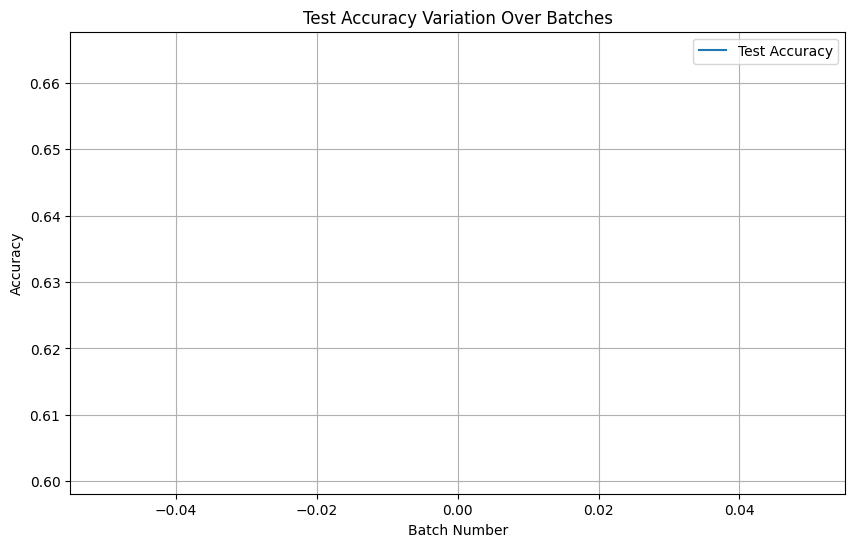

In [31]:
# test accuracy variation
plt.figure(figsize=(10, 6))
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Variation Over Batches')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

# Load the test data
test_loader = test_loader

# Evaluate the model on the test set
avg_test_loss, avg_test_acc, test_accuracy, _ = testSetAccuracy(pretrained_model, test_loader, criterion)

# Make predictions on the test set
true_labels_test = []
predicted_labels_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    pretrained_model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = pretrained_model(inputs)
        predicted_labels_test.extend(torch.argmax(outputs, 1).cpu().numpy())
        true_labels_test.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_test, predicted_labels_test)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels_test, predicted_labels_test, average='weighted')
f1 = f1_score(true_labels_test, predicted_labels_test, average='weighted')

print("Confusion Matrix:")
print(conf_matrix)
print("Test Accuracy (from testSetAccuracy function): {:.4f}".format(test_accuracy))
print("Precision: {:.4f}".format(precision))
print("F1 Score: {:.4f}".format(f1))


Test Batch number: 000, Test: Loss: 0.8430, Accuracy: 0.6329
Test Accuracy (from sklearn): 0.6329
Average Test Loss: 0.8430, Average Test Accuracy: 0.6329
Confusion Matrix:
[[ 0  0  0  3  0]
 [ 0 13  0  0  0]
 [ 0 14 10  0  0]
 [ 0  0  0 26  0]
 [ 0  1  0 11  1]]
Test Accuracy (from testSetAccuracy function): 0.6329
Precision: 0.7587
F1 Score: 0.5659


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


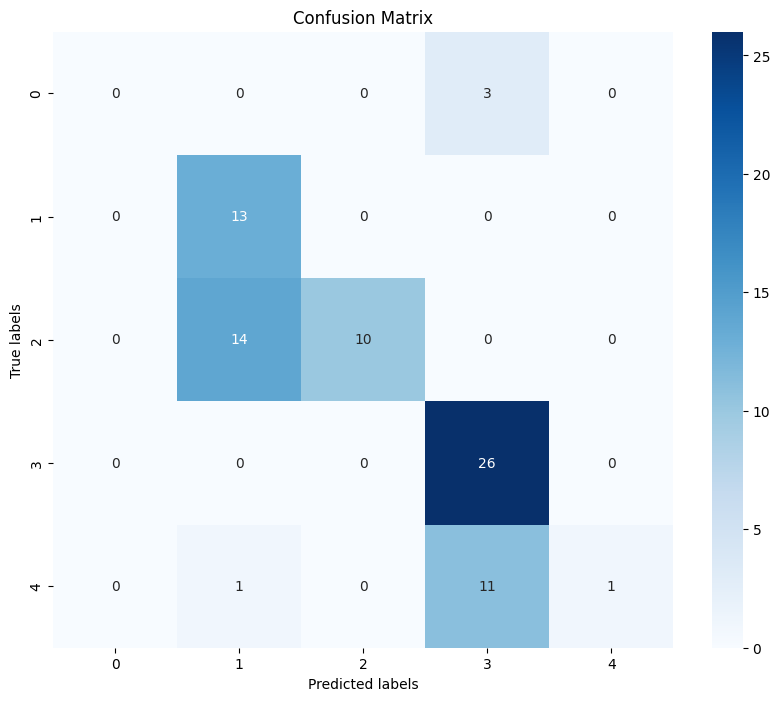

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


#Saving the pretrained Model

In [25]:
# Save the pretrained model
torch.save(pretrained_model, 'pretrained_model.pth')

#Download psdImages_next_iter data

In [26]:
psdImages_next_iter_RGB_path='/content/research_codes/psd_images_combined'

#Displaying sample images

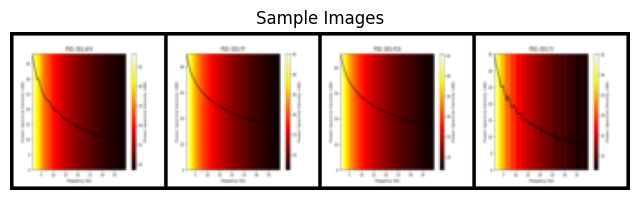

In [27]:
# Display sample images from the dataset
transform_common = transforms.Compose([
        transforms.Resize((84, 84)),
        transforms.ToTensor(),
    ])
psdImages_next_iter_dataset_show = datasets.ImageFolder(root=psdImages_next_iter_RGB_path, transform=transform_common)
sample_loader = torch.utils.data.DataLoader(psdImages_next_iter_dataset_show, batch_size=4, shuffle=True)
sample_batch, sample_labels = next(iter(sample_loader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(vutils.make_grid(sample_batch, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

#Select 100 images and 5 different classes randomly

In [28]:
#Select 100 images and 5 different classes randomly
import random
from shutil import copyfile

# Path to the root directory which has the 10 folders
root_path = "/content/research_codes/psd_images_combined"

# Output path for the new dataset
output_path = "./data_project/psdImages_next_iter_selected_images"
if output_path == './data_project/psdImages_next_iter_selected_images':
  !rm -rf psdImages_next_iter_selected_images

# Getting a list of all folders in the directory
all_folders = os.listdir(root_path)

# Randomly selecting 5 folders
selected_folders = random.sample(all_folders, 5)

# Creating the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# iterating through selected folders
for folder in selected_folders:
  folder_path = os.path.join(root_path, folder)

  # Getting a list of all files in the folder
  all_files = os.listdir(folder_path)

  # Randomly selecting 20 images (will make 100 with all 5 classes)
  selected_images = random.sample(all_files, 20)

  # Creating a subdirectory in the output path for this folder
  output_folder_path = os.path.join(output_path, folder)
  os.makedirs(output_folder_path, exist_ok=True)

  # Copying selected images to the output folder
  for image in selected_images:
      src_path = os.path.join(folder_path, image)
      dest_path = os.path.join(output_folder_path, image)
      copyfile(src_path, dest_path)

print("Dataset creation complete.")

ValueError: Sample larger than population or is negative

In [ ]:
#separate image folders into train test

import random
import os
from shutil import copyfile
def train_test_psdImages_next_iter():
# setting the Path to the root folder containing the folders
  root_path = "./data_project/psdImages_next_iter_selected_images"

  # Output path for the new dataset
  output_path = "./data_project/psdImages_next_iter_tuning"
  if output_path == "./data_project/psdImages_next_iter_tuning":
      !rm -rf psdImages_next_iter_selected_images

  # Getting a list of all folders in the directory
  all_folders = os.listdir(root_path)

  # Creating the output directory if it doesn't exist
  os.makedirs(output_path, exist_ok=True)

  # Creating subfolders for train and test datasets
  train_path = os.path.join(output_path, "train_dataset")
  test_path = os.path.join(output_path, "test_dataset")
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

  # Iterating through selected folders
  for folder in all_folders:
    folder_path = os.path.join(root_path, folder)
    # Create subfolders for each class within train and test datasets
    train_class_path = os.path.join(train_path, folder)
    test_class_path = os.path.join(test_path, folder)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Getting a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Randomly selecting 5 images for training
    train_images = random.sample(all_files, 5)
    for img in train_images:
        src_path = os.path.join(folder_path, img)
        dest_path = os.path.join(train_class_path, img)
        copyfile(src_path, dest_path)

    # Put remaining images into the test dataset
    test_images = set(all_files) - set(train_images)
    for img in test_images:
        src_path = os.path.join(folder_path, img)
        dest_path = os.path.join(test_class_path, img)
        copyfile(src_path, dest_path)

  print("Dataset creation complete.")

#Running the function here
train_test_psdImages_next_iter()

#Creating transforms and data loaders

In [ ]:
def load_psdImages_next_iter_dataset(data_path='./data_project/psdImages_next_iter_tuning/', batch_size=25):
    # Transforms
    image_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(size=216, scale=(0.7, 1.0)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomGrayscale(p=0.1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    # Setting train and test folder paths
    train_dataset_path = os.path.join(data_path, 'train_dataset')
    test_dataset_path = os.path.join(data_path, 'test_dataset')

    # getting number of classes
    num_classes_psdImages_next_iter = len(os.listdir(train_dataset_path))

    # loading Data from folders
    data = {
        'train': datasets.ImageFolder(root=train_dataset_path, transform=image_transforms['train']),
        'test': datasets.ImageFolder(root=test_dataset_path, transform=image_transforms['test'])
    }

    # mapping the indices to the class names
    idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}

    # data size
    train_data_size = len(data['train'])
    test_data_size = len(data['test'])

    # DataLoader
    train_loader = torch.utils.data.DataLoader(data['train'], batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(data['test'], batch_size=batch_size, shuffle=False)
    print("Train Data Size:", train_data_size)
    print("Test Data Size:", test_data_size)

    return train_loader, test_loader, idx_to_class, num_classes_psdImages_next_iter

# Running
train_loader, test_loader, idx_to_class, num_classes = load_psdImages_next_iter_dataset()
class_indices = idx_to_class
print("Class Indices:", idx_to_class)
print("Number of Classes:", num_classes)


# display images with class names

In [ ]:
# display images with class names
def show_images(images, labels, class_names, title):
    plt.figure(figsize=(10, 3))
    plt.suptitle(title, y=1.02, fontsize=16)
    for i in range(min(5, len(images))):
        plt.subplot(1, 5, i + 1)
        plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.show()

# get sample images with class labels from DataLoader
def get_sample(loader, class_names):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    return images, labels, class_names

# Getting a sample from dataset
class_names_psdImages_next_iter = idx_to_class
train_images, train_labels, _ = get_sample(train_loader, class_names_psdImages_next_iter)
test_images, test_labels, _ = get_sample(test_loader, class_names_psdImages_next_iter)

Train = 'Train'
Test = 'Test'
# showing sample images with class names
def show_sample_images(title, images, labels):
  plt.figure(figsize=(10, 3))
  plt.suptitle(title + "Dataset Samples", y=1.02, fontsize=16)
  for i in range(min(5, len(images))):
        plt.subplot(1, 5, i + 1)
        image_np = np.transpose(images[i].numpy(), (1, 2, 0))
        image_np = np.clip(image_np, 0, 1)
        plt.imshow(image_np)
        plt.title(class_names_psdImages_next_iter[labels[i].item()])
        plt.axis('off')
  plt.show()

show_sample_images(Train, train_images, train_labels)
show_sample_images(Test, test_images, test_labels)


In [ ]:
# checking the data type of images
def check_image_data_type(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    data_type = type(images)
    return data_type

# data type of train_loader
train_data_type = check_image_data_type(train_loader)
print("Train Loader Image Data Type:", train_data_type)

# data type of test_loader
test_data_type = check_image_data_type(test_loader)
print("Test Loader Image Data Type:", test_data_type)

#Loading the pre-trained model

In [ ]:
# loading the model

modified_trained_model = torch.load('pretrained_model.pth')
modified_trained_model = modified_trained_model.to(device)

# Setting to evaluation mode
modified_trained_model.eval()

#Adjusting final layer to match class size

In [ ]:
# Freezing all layers
for param in modified_trained_model.parameters():
    param.requires_grad = False
    param.data = param.data.to(device)

# Modifying the final layer
num_classes_psdImages_next_iter = len(class_indices)
dropout = 0.7

# last layer in the Sequential module
in_features = modified_trained_model.fc[-1].in_features

# Replacing the final fully connected layer
modified_trained_model.fc = nn.Sequential(
    nn.ReLU(),
    #add dropout
    nn.Dropout(p=dropout),
    nn.Linear(in_features, num_classes_psdImages_next_iter)
)

# unfreezing the final layer
modified_trained_model.fc.requires_grad = True

# model to the device
modified_trained_model = modified_trained_model.to(device)

In [ ]:
#Training
class Trainer:
    def __init__(self, model, train_loader, optimizer, criterion, scheduler, num_epochs):
      self.model = model
      self.train_loader = train_loader
      self.optimizer = optimizer
      self.criterion = criterion
      self.scheduler = scheduler
      self.num_epochs = num_epochs

    def training(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        self.model = self.model.to(device)

        history = {'train_loss': [], 'train_acc': []}

        for epoch in range(self.num_epochs):
            self.model.train()

            total_loss = 0.0
            true_labels_train = []
            predicted_labels_train = []

            train_loss = 0.0
            train_acc = 0.0

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

                # Computing the accuracy
                predictions = torch.max(outputs.data, 1)[1]
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                train_loss += loss.item() * inputs.size(0)
                train_acc += acc.item() * inputs.size(0)

                true_labels_train.extend(labels.cpu().numpy())
                predicted_labels_train.extend(predictions.cpu().numpy())

            average_loss = total_loss / len(self.train_loader)
            train_accuracy = accuracy_score(true_labels_train, predicted_labels_train)
            history['train_loss'].append(average_loss)
            history['train_acc'].append(train_accuracy)

            print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
            # Updating the learning rate at each epoch
            scheduler.step()

        return history

#Fine tuning Process

In [ ]:
# Setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# number of epochs
num_epochs = 20

# number of episodes
num_episodes = 5

# learning rate
lr = 0.001

# getting the Trainer
optimizer = torch.optim.Adam(modified_trained_model.parameters(), lr=lr, weight_decay=0.3)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

best_model = None
best_accuracy = 0.0
episode_history = {'average_train_loss': [], 'average_train_acc': []}

# Run training for multiple episodes
for episode in range(num_episodes):
    print(f"\nEpisode {episode + 1}/{num_episodes}")

    criterion = nn.CrossEntropyLoss()
    # training for a single episode
    trainer = Trainer(modified_trained_model, train_loader, optimizer, criterion, scheduler, num_epochs=num_epochs)

    #data loaders
    train_loader, test_loader, idx_to_class, num_classes = load_psdImages_next_iter_dataset()

    # sample from each dataset to print
    class_names_psdImages_next_iter = idx_to_class
    train_images, train_labels, _ = get_sample(train_loader, class_names_psdImages_next_iter)
    test_images, test_labels, _ = get_sample(test_loader, class_names_psdImages_next_iter)

    #show sample images
    show_sample_images(Train, train_images, train_labels)
    show_sample_images(Test, test_images, test_labels)

    # train the model
    history = trainer.training()

    # average training loss and accuracy for all epochs
    average_training_loss = sum(history['train_loss']) / len(history['train_loss'])
    average_training_accuracy = sum(history['train_acc']) / len(history['train_acc'])
    episode_history['average_train_loss'].append(average_training_loss)
    episode_history['average_train_acc'].append(average_training_accuracy)

    # updating the best model if the current accuracy is the best
    if average_training_accuracy > best_accuracy:
        best_accuracy = average_training_accuracy
        best_model = modified_trained_model
    !rm -rf psdImages_next_iter_selected_images
    !rm -rf psdImages_next_iter_tuning

    print(f"Average Training Loss: {average_training_loss:.4f}, Average Training Accuracy: {average_training_accuracy:.4f}")

    # updating learning rate
    scheduler.step()

# saving the best model
torch.save(best_model, 'best_fine_tuned_model.pth')
print("Best model saved.")

# Plotting loss and accuracy variations

In [ ]:
# Plotting loss and accuracy variations
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(episode_history['average_train_loss'], label='Average Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_history['average_train_acc'], label='Average Training Accuracy')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# loading the model
best_fine_tuned_model = torch.load('best_fine_tuned_model.pth')

# moving the model to the device
best_fine_tuned_model = best_fine_tuned_model.to(device)

# setting the model to evaluation mode
best_fine_tuned_model.eval()

In [ ]:
#testing
def testSetAccuracy(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    true_labels_test = []
    predicted_labels_test = []

    # collecting test accuracy history
    test_acc_history = []

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # test loop
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass computing outputs on input data
            outputs = model(inputs)

            # computing loss
            loss = criterion(outputs, labels)

            # collecting the loss
            test_loss += loss.item() * inputs.size(0)

            # accuracy calculation
            true_labels_test.extend(labels.cpu().numpy())
            predicted_labels_test.extend(torch.argmax(outputs, 1).cpu().numpy())

            # Calculate accuracy
            correct_counts = torch.sum(torch.argmax(outputs, 1) == labels)
            acc = correct_counts.item() / labels.size(0)

            # Accumulate accuracy
            test_acc += acc * inputs.size(0)

            # collecting test accuracy
            test_acc_history.append(acc)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc))

    # average test loss and test accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_acc = test_acc / len(test_loader.dataset)

    # accuracy using scikit-learn
    test_accuracy = accuracy_score(true_labels_test, predicted_labels_test)

    print("Test Accuracy (from sklearn): {:.4f}".format(test_accuracy))
    print("Average Test Loss: {:.4f}, Average Test Accuracy: {:.4f}".format(avg_test_loss, avg_test_acc))

    # return values
    return avg_test_loss, avg_test_acc, test_accuracy, test_acc_history


#Testing process

In [ ]:
# Testing
_, test_loader, _, _  = load_psdImages_next_iter_dataset()
avg_test_loss, avg_test_acc, test_accuracy, test_acc_history = testSetAccuracy(best_fine_tuned_model, test_loader, criterion)
print("avg_test_loss: ", avg_test_loss)
print("avg_test_Accuracy: ", avg_test_acc)
print("test_Accuracy: {:.4f}".format(test_accuracy))


#plotting the testing accuracy

In [ ]:
_, _, _, test_acc_history = testSetAccuracy(best_fine_tuned_model, test_loader, criterion)
# Plotting test accuracy
plt.figure(figsize=(10, 6))
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Variation Over Batches')
plt.legend()
plt.grid(True)
plt.show()

#checking the model summary

In [ ]:
!pip install torchsummary
from torchsummary import summary

summary(modified_trained_model, (3, 224, 224))

#Predictions using web images

In [ ]:
#data loader
train_loader, test_loader, class_indices, num_classes = load_psdImages_next_iter_dataset()
#transforms
image_transforms = {
        'train': transforms.Compose([
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
        ])
    }
#prediction
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    test_image = transform(test_image)
    plt.imshow(test_image.permute(1, 2, 0))
    test_image_tensor = test_image.unsqueeze(0)
    test_image_tensor = test_image_tensor.to(device)

    with torch.no_grad():
        model.eval()
        # log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(3, dim=1)
        print("Class Indices:", idx_to_class)
        print("Model Output:", topclass.cpu().numpy()[0])

        for i in range(3):
            print("Prediction", i + 1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])


# predicting the image using the best tested model

In [ ]:
# predicting the image using the best tested model
! wget https://cdn.pixabay.com/photo/2015/10/06/19/28/trees-975091_960_720.jpg -O image.jpg

model = torch.load("best_fine_tuned_model.pth")
predict(model, 'image.jpg')

# predicting the image using the best tested model 2

In [ ]:
# predicting the image using the best tested model
! wget https://cdn.pixabay.com/photo/2019/06/19/16/40/bridge-4285310_960_720.jpg -O image.jpg

model = torch.load("best_fine_tuned_model.pth")
predict(model, 'image.jpg')